# SPEARBO GP - compare tfgp, SK, GPy for hyperparameters tuning


This code compares the hyper-parameters training results from 3 different codes:
- tfgp_trainer - developed at SLAC on Tensorflow
- GP regression from SK Learn
- GP regression from GPy

# import

In [2]:
#%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import sys
import warnings
warnings.filterwarnings("ignore")

# enlarge fonts
import matplotlib
font = {'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(100,) (100, 1)


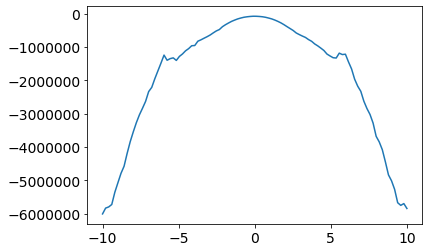

In [3]:
Y=np.load('emit_list_ref_H1=-10_10_100steps.npy')
X= np.load('hex_list_ref_H1=-10_10_100steps.npy')
plt.plot(X,Y)
print(X.shape,Y.shape)

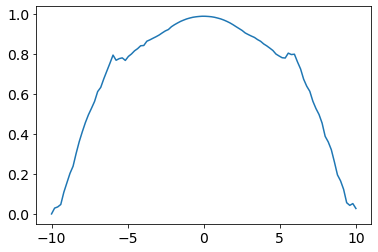

In [13]:
Xin = X[:,None]
yin = (Y.flatten()-Y.min())/6e6
plt.plot(Xin,yin)

# TFGP trainer

In [16]:
import sys
sys.path.append('C:\\Users\\Adi\\Dropbox (Technion Dropbox)\\ML\\GP\\main_code')
from tfgp_trainer_v2 import tfgp_trainer
from utils import *

t0 = time.time()
print('Xin.shape', Xin.shape)
print('Yin.shape', yin.shape)
Niter = 2000

tf.reset_default_graph() 
tfgp_D = tfgp_trainer(Xin, yin)
tfgp_D.train_corr(lr=0.005, niter=Niter,
             optimizer=[tf.compat.v1.train.AdamOptimizer, tf.compat.v1.train.GradientDescentOptimizer, tf.compat.v1.train.RMSPropOptimizer][0],
             gradient_clipping=0,
             kernel=['rbf','matern32','matern52'][0],
             correlations = False,
             offset = False,
             monitor_period=None,
             monitor_gradient=None) # pts by pts matrix inversion


Xin.shape (100, 1)
Yin.shape (100,)


100% (2000 of 2000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


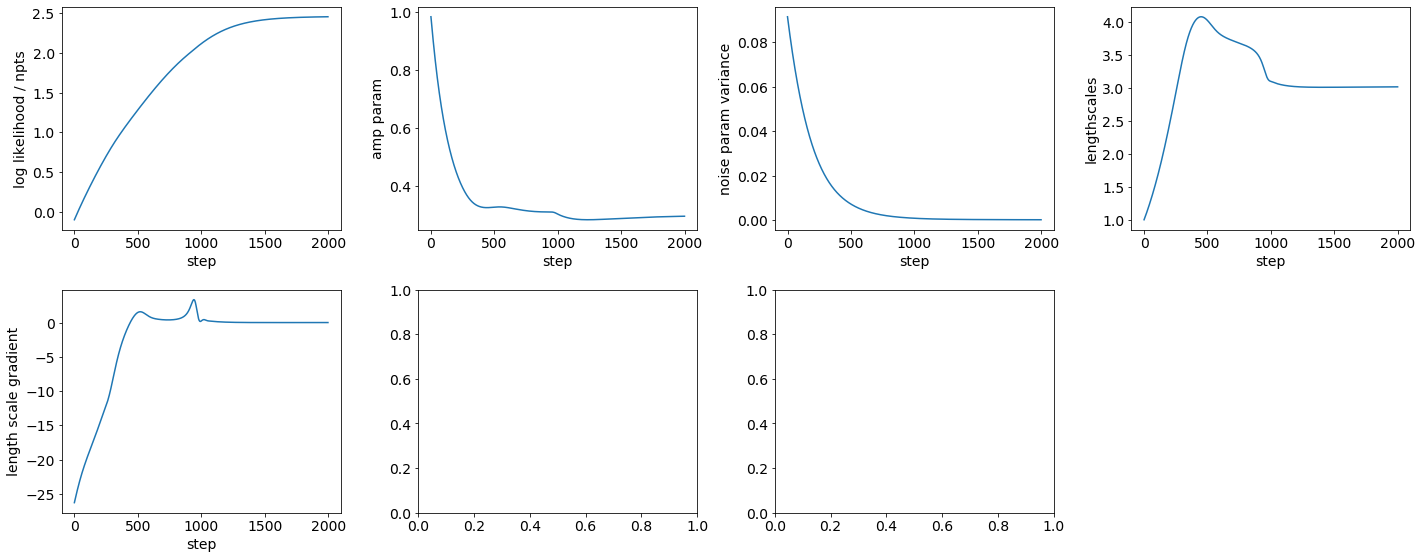

logLiklihod 245.50694144186832 
 amp 0.2941434822568276 
 noise 0.00010801861458088368 
 ls [3.01335022]
took  13.451504945755005  seconds


In [17]:
precision_matrix, amp_param, noise_param_variance, length_scale_param = GP_plot_results(tfgp_D,yin)
# precision_matrix, amp_param, noise_param_variance, length_scale_param, offset_param = GP_plot_results(tfgp_D,yin)

tfgp_t = time.time()-t0
print ('took ',tfgp_t ,' seconds')

# SK learn

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Ck, WhiteKernel


X_train = Xin
y_train = yin

se_ard = Ck(10.0)*RBF(length_scale=np.array([1.0]*X_train.shape[1]), length_scale_bounds=(0.000001,20))

noise = WhiteKernel(noise_level=0.1**2,
                noise_level_bounds=(1e-5, 100))  # noise terms

sk_kernel = se_ard + noise #+ Ck(0.0) #+offset kernel

t0=time.time()
gpr = GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=5)
gpr.fit(X_train, y_train)
sk_t = time.time()-t0
print ('took ',sk_t ,' seconds')

print("\nLearned kernel: %s" % gpr.kernel_)
print("Log-marginal-likelihood: %.3f" % gpr.log_marginal_likelihood(gpr.kernel_.theta))

took  0.25631260871887207  seconds

Learned kernel: 0.546**2 * RBF(length_scale=3.02) + WhiteKernel(noise_level=0.000181)
Log-marginal-likelihood: 245.927


In [25]:
sk_ls = gpr.kernel_.get_params()['k1__k2__length_scale']
sk_noise = gpr.kernel_.get_params()['k2__noise_level']
sk_amp = gpr.kernel_.get_params()['k1__k1']
# sk_offset = gpr.kernel_.get_params()['k2__constant_value']
# gpr.kernel_.get_params()

# GPy

In [26]:
import GPy

max_iters=1000
X_train = Xin
y_train = yin[:,None]

gpy_kernel = GPy.kern.RBF(X_train.shape[1],ARD = 1) + GPy.kern.White(X_train.shape[1]) + GPy.kern.Bias(1)

gpr_gpy = GPy.models.GPRegression(X_train, y_train, gpy_kernel)

# len_prior = GPy.priors.inverse_gamma(1,18) # 1, 25
# m.set_prior('.*lengthscale',len_prior)

t0=time.time()
gpr_gpy.optimize(optimizer='lbfgs', max_iters=max_iters)
gpr_gpy.optimize_restarts(num_restarts = 5)
gpy_t = time.time()-t0
print ('took ', gpy_t,' seconds')


Optimization restart 1/5, f = -247.34098429198417
Optimization restart 2/5, f = -247.34098427328314
Optimization restart 3/5, f = -247.34098424789383
Optimization restart 4/5, f = -247.34098429219054
Optimization restart 5/5, f = -255.4917983590859
took  1.0222666263580322  seconds


In [27]:
gpy_lengthscale = np.array(gpr_gpy.to_dict()['kernel']['parts'][0]['lengthscale'])
gpy_amp = np.array(gpr_gpy.to_dict()['kernel']['parts'][0]['variance'])[0]
gpy_noise = gpr_gpy.to_dict()['kernel']['parts'][1]['variance'][0]
bias_std = (gpr_gpy.to_dict()['kernel']['parts'][2]['variance'])[0]

# GPFLOW

In [29]:
# import gpflow
# import numpy as np
# import tensorflow as tf

# k = gpflow.kernels.RBF(1, lengthscales=np.ones(X_train.shape[1]))
# m = gpflow.models.GPR(data=(Xin, yin), kernel=k, mean_function=None)

# model.likelihood.variance = 0.01

# model.optimize(disp=True, maxiter=1000)

In [31]:
# collect the results into a pandas dataframe to display
pd.DataFrame({"Param": ['time','lik', 'amp', 'noise', 'offset', 'ls'],
              "tfgp": [tfgp_t,tfgp_D.results['logLikelihood'][-1], amp_param, noise_param_variance , offset_param, length_scale_param.tolist()],
              "SK": [sk_t,gpr.log_marginal_likelihood(gpr.kernel_.theta), sk_amp, sk_noise, sk_offset, sk_ls.tolist() ],
              "GPy": [gpy_t,-gpr_gpy.objective_function(), gpy_amp, gpy_noise , bias_std, gpy_lengthscale.tolist()]
             })


,Param,tfgp,SK,GPy
0,time,13.4515,0.256313,1.02227
1,lik,245.507,245.927,255.492
2,amp,0.294143,0.546**2,0.0724354
3,noise,0.000108019,0.000180519,5.90511e-05
4,offset,2.7664,0.331024,0.331008
5,ls,[3.01335022259403],3.01732,[1.3004524090806182]


In [64]:
pd.DataFrame({"": X.keys(),
              "tfgp": length_scale_param.tolist(),
              "SK": sk_ls.tolist() ,
              "GPy": gpy_lengthscale.tolist()
             })

,,tfgp,SK,GPy
0,01,7.338307,7.087266,7.090163
1,02,3.890636,3.537404,3.543097
2,05,19.802359,13.489668,13.444399
3,07,5.338388,4.824858,4.826947
4,08,15.656801,20.000000,20.692370
5,09,14.920406,10.660518,10.653634
6,10,6.345028,6.104251,6.111039
7,11,3.093728,2.735591,2.736248
8,12,8.077224,6.117417,6.118054
9,14,16.970115,12.536147,12.490646


# Baysiean optimization of hyperparameters using GPyOpt

In [23]:
# import GPyOpt
# from GPyOpt.methods import BayesianOptimization

# kernel = gpy_kernel #GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
# bds = [{'name': 'Xin', 'type': 'continuous', 'domain': (-20,20)},
#        {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)}]
 
# objective_func = 1

# optimizer = BayesianOptimization(f= objective_func, 
#                                  domain=bds,
#                                  model_type='GP',
#                                  kernel=kernel,
#                                  acquisition_type ='LCB',
#                                  acquisition_jitter = 0.01,
#                                  X=Xin,
#                                  Y=-yin,
#                                  noise_var = noise**2,
#                                  exact_feval=False,
#                                  normalize_Y=False,
#                                  maximize=True)

# optimizer.run_optimization(max_iter=10)
# optimizer.plot_acquisition()
# optimizer.plot_convergence()